In [24]:
import pandas as pd
import spacy
from spacy import displacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import string
import nltk
import en_core_web_sm
#nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm')
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
import random
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [2]:
dftry2 = pd.read_csv("posts_st.txt",
                    sep = '|',
                    names = ['AUTHOR','ID','SCORE','CREATED_DATE','TITLE','NUM_COMMENTS','SELFTEXT'],
                    header=None, lineterminator = "\n")

### Removing where the title or the selftext are null and removing the posts where the moderator for the Subreddit deleted/removed the post or the original author deleted/removed the post.

In [3]:
dftry2.dropna(subset=['TITLE'], inplace = True)
dftry2.dropna(subset=['SELFTEXT'], inplace = True)
df_touse = dftry2[dftry2['SELFTEXT'] != "[removed]"].copy()
df_to_use_fin = df_touse[df_touse['SELFTEXT'] != "[deleted]"].copy()
df_to_use_fin['FULL_POSTS'] = df_to_use_fin['TITLE']+"."+" "+df_touse['SELFTEXT']

### Only keeping posts from the release date of season 3 to current.  This just mirrors our supervised learning portion - although unrelated to one another except for both surround Stranger Things - we did not expect to bring back so much data from the pushshift api.

In [4]:
df_to_use_fin['CREATED_DATE'] = pd.to_datetime(df_to_use_fin['CREATED_DATE'])
df_to_use_fin = df_to_use_fin[df_to_use_fin['CREATED_DATE']> "2019-07-04"].copy()

### Text Cleaning Function, removes web address which holds links and appears when someone posts a png or jpg. They do many hand drawings of characters or scenes from the show in the subreddit. Then the function sets text to lower case and then removes all punctuation. Then utilizing spacy nlp we find the words lemma and then kick it out if it is a stop words, or is an instance of non alpha characters (such as numbers), then it removes if the word itself is less than 2 chars and finally removes the word if the word's part of speech is not in the allowed parts of speech list we have.

In [5]:
# Text Cleaning Function
import re

def clean(text):
    allowed_postags=["NOUN", "VERB", "ADJ", "ADV", "ADP", "PROPN"]
    
    try: 
        text1 = re.sub(r"http\S+", "", text)
        #Convert text in lower case
        text2 = text1.lower()
        #text3 = text2.replace("[^a-zA-Z#]", " ")
        #Removing Punctuations
        punc_removed = text2.translate(str.maketrans('', '', string.punctuation))
        doc= nlp(punc_removed)
        text_out = [token.lemma_ for token in doc if token.is_stop == False and \
                    token.is_alpha and len(token)>2 and token.pos_ in allowed_postags\
                   ]
        #txt = ' '.join(text_out)
    except:
        #txt = ''
        text_out = ''
    return text_out

In [6]:
df_to_use_fin['token_lemma'] = df_to_use_fin['FULL_POSTS'].apply(clean)

### Getting the sentiment by utilizing vader 

In [10]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def polarity(text):
    pol = sid.polarity_scores(text)
    return pol
#polarity checking
def joiner(text):
    txt = ' '.join(text)
    return txt
df_to_use_fin['FULL_POSTS_CLEAN'] = df_to_use_fin['token_lemma'].apply(joiner)
df_to_use_fin['polarity'] = df_to_use_fin['FULL_POSTS_CLEAN'].apply(polarity)
df_to_use_fin['compound']  = df_to_use_fin['polarity'].apply(lambda score_dict: score_dict['compound'])

df_to_use_fin['sentiment'] = df_to_use_fin['compound'].apply(lambda x: "Positive" if x>0 else("Negative" if x<0 else "Neutral") )
print("polarity checked successfull")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jacquelineskunda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


polarity checked successfull


### Removal of posts where the tokenized and lemmatized title+selftext, aka POSTS, have a length less than 5.  We believe this will help create more defined topics and also alleviates the issues where the poster only posted a short blurb of words and some sort of image/vid or a hyperlink elsewhere.

In [11]:
df_to_use_fin['tok_len'] = df_to_use_fin['token_lemma'].apply(lambda x: len(x))
df_to_use_fin.groupby(['tok_len'])['tok_len'].count()[2759]
df_to_use_fin = df_to_use_fin[df_to_use_fin['tok_len']>=5].copy()
#checking shape to see how much data we have
df_to_use_fin.shape

(30660, 14)

### Vectorization method - TF_IDF

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
tf_idf_vectorizor = TfidfVectorizer(max_features = 20000) #1
tf_idf = tf_idf_vectorizor.fit_transform(list(df_to_use_fin['FULL_POSTS_CLEAN'])) #2
#tf_idf_array = tf_idf.toarray() 
X = pd.DataFrame(tf_idf.toarray(),columns=tf_idf_vectorizor.get_feature_names_out())#4

In [34]:
X.shape

(30660, 20000)

### Kmeans clustering

In [16]:
#Looking at Kmeans using standard 10 topics for K

num_clusters = 10
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, 
                          random_state = 100,
                         verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(tf_idf)
#kmeans_clusters = kmeans.predict(tf_idf)
#kmeans_distances = kmeans.transform(tf_idf)
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vectorizor.get_feature_names_out()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    for j in sorted_centroids[i, :5]:
        print(' %s' % terms[j])
    print()

Cluster 0:
 flayer
 mind
 vecna
 upside
 season

Cluster 1:
 song
 play
 season
 music
 know

Cluster 2:
 vecna
 max
 kill
 think
 theory

Cluster 3:
 strange
 thing
 watch
 season
 stranger

Cluster 4:
 steve
 nancy
 robin
 jonathan
 season

Cluster 5:
 upside
 gate
 open
 demogorgon
 season

Cluster 6:
 hopper
 russian
 joyce
 american
 season

Cluster 7:
 season
 watch
 episode
 think
 like

Cluster 8:
 character
 mike
 like
 season
 think

Cluster 9:
 think
 know
 like
 season
 episode



/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Finding Ideal number of topics

### Elbow Method

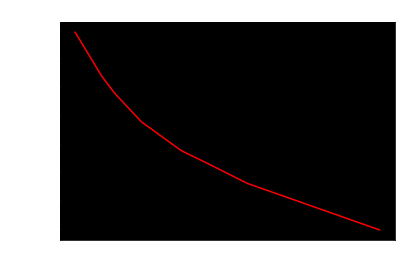

In [52]:
Sum_of_squared_distances = []
K = [4,8,10,14,20,24,30,50]
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters,init='k-means++', 
                          random_state = 100)
    kmeans.fit(tf_idf)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.rcParams['axes.facecolor'] = 'black'
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
plt.plot(K,Sum_of_squared_distances,'r-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

### The elbow method is not distinguishing a great K, this could be due to the data coming all from the same subreddit so it is not exhibiting well seperated clusters.  Also this means we will have to try a silouhette score instead which will help determine a ideal k.  The plot shows inertia keeps decreasing as K increases. Tthere is a turning point in terms of the inertia decreasing speed, and this is the Elbow point we should look for. Note that when we generate the data, we use three normal distributions. Thus it matches the result based 
"The silhouette value for each point is a measure of how similar that point is to points in its own cluster compared to points in other clusters, and ranges from -1 to +1.

The silhouette value for the ith point, Si, is defined as

Si = (bi-ai)/ max(ai,bi) where ai is the average distance from the ith point to the other points in the same cluster as i, and bi is the minimum average distance from the ith point to points in a different cluster, minimized over clusters."

### Silouhette Score

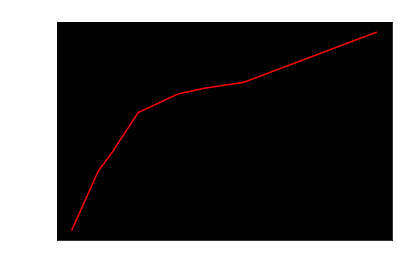

In [84]:
range_n_clusters = [4,8,10,14,20,24,30,50]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans_sil = KMeans(n_clusters=num_clusters,init='k-means++', n_init=10, 
                          random_state = 100,
                        )
    kmeans_sil.fit(tf_idf)
    cluster_labels = kmeans_sil.labels_
 
    # silhouette score
    silhouette_avg.append(silhouette_score(tf_idf, cluster_labels, metric = 'euclidean'))
plt.plot(range_n_clusters,silhouette_avg,'r-')
plt.rcParams['axes.facecolor'] = 'black'
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

### The best value is 1 and the worst value is -1 for silouhette scores. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. It would make sense that there are overlapping clusters since the data stems from the same subreddit, hence have silhouette scores around 0. Just by eyeing both plots it looks like there is a slight bend around 14 and one around, 20 and 30.  We will run all 3 and get there various metrics out for comparison.

### Def below from sklearn documentation this we will use to pull out the different metrics for comparison. We are running on samples of 10K since this will take a while.
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

In [54]:
kmeans14 = KMeans(n_clusters=14, init='k-means++', n_init=10, 
                          random_state = 100,
                         verbose=False, max_iter=1000)
kmeans20 = KMeans(n_clusters=20, init='k-means++', n_init=10, 
                          random_state = 100,
                         verbose=False, max_iter=1000)
kmeans30 = KMeans(n_clusters=30, init='k-means++', n_init=10, 
                          random_state = 100,
                         verbose=False, max_iter=1000)

In [81]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics

def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time.time()
    estimator = make_pipeline(StandardScaler(with_mean=False), kmeans).fit(data)
    #cluster_labels = estimator.labels_
    fit_time = time.time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            #sample_size=20000,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return formatter_result.format(*results)
k_results_14 = bench_k_means(kmeans14, name = "14 Clusters k-means++", data = tf_idf.T, \
                             labels = tf_idf_vectorizor.get_feature_names_out())
k_results_20 = bench_k_means(kmeans20, name = "20 Clusters k-means++", data = tf_idf.T, \
                             labels = tf_idf_vectorizor.get_feature_names_out())
k_results_30 = bench_k_means(kmeans30, name = "30 Clusters k-means++", data = tf_idf.T, \
                             labels = tf_idf_vectorizor.get_feature_names_out())

14 Clusters k-means++	3.611s	584959164	0.006	1.000	0.012	0.000	-0.000	0.560
20 Clusters k-means++	4.968s	575118026	0.008	1.000	0.015	0.000	-0.000	0.707
30 Clusters k-means++	11.703s	558941725	0.014	1.000	0.027	0.000	0.000	0.682


#### Time, Inertia, Homogeneity score, Completeness, V measure, Adjusted Rand Score, Adjusted Mutual Information Score, Silouhette Score.  From sklearn documentation:     
**Inertia:** For better clustering, the inertia value should be minimum. In contrast, if the inertia value is high, that means data points in the cluster are not similar to each other.   
**Homogeneity:** A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class. Score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.    
**Completeness:** float. Score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.    
**V_measure:** float. score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.    
**ARI:** The ARI returns similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match. See also adjusted_mutual_info_score.  
**AMI:** The AMI returns a value of 1 when the two partitions are identical (ie perfectly matched). Random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative.   
**Silhouette:** The best value is 1 and the worst value is -1 for silouhette scores. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.   

In [80]:
tf_idf.T.shape

(20000, 30660)

In [76]:
tf_idf_vectorizor.get_feature_names_out().shape

(20000,)

### Based on our results it looks like 20 or 30 clusters would be ideal  20 has the highest silhouette score, but 30 clusters has the better values for the other metrics and came in second for silhouette score.

### Using KMeans with ideal number of Topics

In [87]:
#Looking at Kmeans using 20 topics for K

num_clusters = 20
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, 
                          random_state = 100,
                         verbose=False, max_iter=1000)
kmeans_20 = kmeans_model.fit(tf_idf)
#kmeans_clusters = kmeans.predict(tf_idf)
#kmeans_distances = kmeans.transform(tf_idf)

In [120]:
sorted_centroids = kmeans_20.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vectorizor.get_feature_names_out()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    tops = []
    for j in sorted_centroids[i, :10]:
        curr_word = terms[j]
        tops.append(terms[j])
        #print(' %s' % terms[j])
    print(tops)

Cluster 0:
['brenner', 'think', 'lab', 'season', 'know', 'power', 'child', 'theory', 'kid', 'kill']
Cluster 1:
['think', 'like', 'season', 'know', 'scene', 'thing', 'time', 'go', 'look', 'people']
Cluster 2:
['billy', 'max', 'season', 'think', 'scene', 'die', 'like', 'billys', 'know', 'character']
Cluster 3:
['vecna', 'max', 'kill', 'think', 'theory', 'season', 'mind', 'like', 'know', 'upside']
Cluster 4:
['watch', 'season', 'time', 'thing', 'strange', 'finish', 'episode', 'start', 'like', 'good']
Cluster 5:
['season', 'think', 'like', 'end', 'good', 'feel', 'time', 'go', 'thing', 'release']
Cluster 6:
['episode', 'season', 'think', 'watch', 'like', 'know', 'end', 'volume', 'scene', 'time']
Cluster 7:
['character', 'season', 'like', 'die', 'think', 'main', 'feel', 'death', 'kill', 'good']
Cluster 8:
['mike', 'season', 'like', 'love', 'think', 'friend', 'gay', 'say', 'max', 'know']
Cluster 9:
['song', 'play', 'season', 'music', 'know', 'soundtrack', 'hill', 'vecna', 'episode', 'run']
Cl

### Visualizing our Clusters

In [106]:
results_final = pd.DataFrame()
results_final['post'] = df_to_use_fin.FULL_POSTS_CLEAN
results_final['category'] = kmeans_20.labels_
results_final

,post,category
1,upsidedown turn vecna survive reason vecna los...,3
2,season rewatch question go killing spree lab k...,5
8,dear billy vecna episode kid convince evil cal...,3
9,child vecna season notice second big mystery u...,11
13,theory spoiler vecna control think mind flayer...,1
...,...,...
48331,time relationship struggle call murray guy work,1
48333,minor spoilersthought kline sign look familiar...,1
48334,spoiler sure season way see episode spoiler,6
48335,episode joyce watch friend episode diane marry...,6


In [ ]:
from sklearn.decomposition import SparsePCA
reduced_data = SparsePCA(n_components=2, random_state = 100).fit_transform(tf_idf.toarray())
kmeansFin = KMeans(init="k-means++", n_clusters=20, n_init=10,
                   random_state = 100,max_iter=1000)
kmeansFin.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeansFin.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering 20 Topics"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Possibly add on features of date of post and sentiment compound to help cluster, this doesnt seem like these feature add ons would be out of scope or "cheating" since we would always know when a subreddit post was made and the sentiment is a calculation

In [ ]:
df_fin_to_use